In [1]:
spark

In [40]:
from pyspark.sql.functions import col, isnan, isnull, when, count, udf, mean
from pyspark.sql.types import StructType, StructField, StringType, FloatType, IntegerType
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from synapse.ml.isolationforest import IsolationForest

In [4]:
#Set up the path
bucket = 'my-bigdata-project-ar/'
filename = 'cleaned/cleaned_physicians_and_other_supplier.parquet'
file_path = 'gs://' + bucket + filename 

#Define schema for dataset
schema = StructType([
    StructField("npi", StringType(), nullable=False),
    StructField("provider_type", StringType(), nullable=True),
    StructField("hcpcs_code", StringType(), nullable=False),
    StructField("hcpcs_drug_indicator", StringType(), nullable=True),
    StructField("line_srvc_cnt", FloatType(), nullable=True),
    StructField("bene_unique_cnt", IntegerType(), nullable=True),
    StructField("bene_day_srvc_cnt", IntegerType(), nullable=True),
    StructField("average_medicare_allowed_amt", FloatType(), nullable=True),
    StructField("average_submitted_chrg_amt", FloatType(), nullable=True),
    StructField("average_medicare_payment_amt", FloatType(), nullable=True),
])


# Read data from GCS bucket to spark DF
sdf = spark.read.schema(schema).parquet(file_path)

In [5]:
sdf.columns

['npi',
 'provider_type',
 'hcpcs_code',
 'hcpcs_drug_indicator',
 'line_srvc_cnt',
 'bene_unique_cnt',
 'bene_day_srvc_cnt',
 'average_medicare_allowed_amt',
 'average_submitted_chrg_amt',
 'average_medicare_payment_amt']

In [6]:
sdf.printSchema()

root
 |-- npi: string (nullable = true)
 |-- provider_type: string (nullable = true)
 |-- hcpcs_code: string (nullable = true)
 |-- hcpcs_drug_indicator: string (nullable = true)
 |-- line_srvc_cnt: float (nullable = true)
 |-- bene_unique_cnt: integer (nullable = true)
 |-- bene_day_srvc_cnt: integer (nullable = true)
 |-- average_medicare_allowed_amt: float (nullable = true)
 |-- average_submitted_chrg_amt: float (nullable = true)
 |-- average_medicare_payment_amt: float (nullable = true)



In [7]:
sdf.count()

37254908

In [8]:
sdf.select('line_srvc_cnt','bene_unique_cnt','bene_day_srvc_cnt').summary("count", "min", "max", "mean").show()

+-------+------------------+-----------------+------------------+
|summary|     line_srvc_cnt|  bene_unique_cnt| bene_day_srvc_cnt|
+-------+------------------+-----------------+------------------+
|  count|          37254908|         37254908|          37254908|
|    min|               3.0|               11|                11|
|    max|         5313837.0|           741837|           2290882|
|   mean|241.93267680606237|90.95219561406513|149.25397818724986|
+-------+------------------+-----------------+------------------+



In [9]:
sdf.select( 'average_medicare_allowed_amt',
 'average_submitted_chrg_amt',
 'average_medicare_payment_amt').summary("count", "min", "max", "mean").show()

+-------+----------------------------+--------------------------+----------------------------+
|summary|average_medicare_allowed_amt|average_submitted_chrg_amt|average_medicare_payment_amt|
+-------+----------------------------+--------------------------+----------------------------+
|  count|                    37254908|                  37254908|                    37254908|
|    min|                  3.33333E-5|                       0.0|                         0.0|
|    max|                   52601.473|                  98099.82|                   37012.324|
|   mean|           97.80453057486234|        188.57081105988655|           74.55727346089903|
+-------+----------------------------+--------------------------+----------------------------+



In [10]:
numeric_cols = ['line_srvc_cnt',
 'bene_unique_cnt',
 'bene_day_srvc_cnt',
 'average_medicare_allowed_amt',
 'average_submitted_chrg_amt',
 'average_medicare_payment_amt']

for col_name in numeric_cols:
    sdf = sdf.withColumn(col_name, col(col_name).cast('float'))

In [11]:
sdf.printSchema()

root
 |-- npi: string (nullable = true)
 |-- provider_type: string (nullable = true)
 |-- hcpcs_code: string (nullable = true)
 |-- hcpcs_drug_indicator: string (nullable = true)
 |-- line_srvc_cnt: float (nullable = true)
 |-- bene_unique_cnt: float (nullable = true)
 |-- bene_day_srvc_cnt: float (nullable = true)
 |-- average_medicare_allowed_amt: float (nullable = true)
 |-- average_submitted_chrg_amt: float (nullable = true)
 |-- average_medicare_payment_amt: float (nullable = true)



In [12]:
input_cols = ['line_srvc_cnt', 'bene_unique_cnt', 'bene_day_srvc_cnt',
              'average_medicare_allowed_amt', 'average_submitted_chrg_amt',
              'average_medicare_payment_amt']

categorical_cols = ['provider_type', 'hcpcs_code', 'hcpcs_drug_indicator']


indexers = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in categorical_cols]
encoders = [OneHotEncoder(inputCol=column+"_index", outputCol=column+"_vector") for column in categorical_cols]

input_cols += [column + "_vector" for column in categorical_cols]
print(input_cols)
assembler = VectorAssembler(inputCols=input_cols, outputCol="features")


scaler = StandardScaler(inputCol="features", outputCol="scaled_features")





['line_srvc_cnt', 'bene_unique_cnt', 'bene_day_srvc_cnt', 'average_medicare_allowed_amt', 'average_submitted_chrg_amt', 'average_medicare_payment_amt', 'provider_type_vector', 'hcpcs_code_vector', 'hcpcs_drug_indicator_vector']


In [13]:
medicare_pipe = Pipeline(stages=indexers + encoders + [assembler, scaler])

transformed_sdf = medicare_pipe.fit(sdf).transform(sdf)

transformed_sdf.columns


['npi',
 'provider_type',
 'hcpcs_code',
 'hcpcs_drug_indicator',
 'line_srvc_cnt',
 'bene_unique_cnt',
 'bene_day_srvc_cnt',
 'average_medicare_allowed_amt',
 'average_submitted_chrg_amt',
 'average_medicare_payment_amt',
 'provider_type_index',
 'hcpcs_code_index',
 'hcpcs_drug_indicator_index',
 'provider_type_vector',
 'hcpcs_code_vector',
 'hcpcs_drug_indicator_vector',
 'features',
 'scaled_features']

In [ ]:
bucket = 'my-bigdata-project-ar/'
filename = 'trusted/trusted_physicians_and_other_supplier.parquet'
file_path = 'gs://' + bucket + filename 

transformed_sdf.write.mode("overwrite").parquet(file_path)

In [14]:
sample_sdf = transformed_sdf.sample(False, .1)
train_data, test_data = sample_sdf.randomSplit([0.7, 0.3], seed=42)

print(f"Train data row count: {train_data.count()}\n Test data row count: {test_data.count()}")

24/05/06 03:03:53 WARN DAGScheduler: Broadcasting large task binary with size 1215.5 KiB
24/05/06 03:04:20 WARN DAGScheduler: Broadcasting large task binary with size 1215.5 KiB


Train data row count: 2604837
 Test data row count: 1115919


In [15]:
iforest = IsolationForest(featuresCol='scaled_features', predictionCol='predicted_label',
                          contamination=0.005, scoreCol="outlierScore", numEstimators=50)

model = iforest.fit(train_data)


24/05/06 03:04:44 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/05/06 03:04:45 WARN DAGScheduler: Broadcasting large task binary with size 1263.5 KiB
24/05/06 03:04:56 WARN DAGScheduler: Broadcasting large task binary with size 1267.7 KiB
24/05/06 03:06:06 WARN DAGScheduler: Broadcasting large task binary with size 1276.4 KiB
24/05/06 03:07:31 WARN DAGScheduler: Broadcasting large task binary with size 1343.6 KiB
24/05/06 03:47:01 WARN DAGScheduler: Broadcasting large task binary with size 1344.7 KiB
24/05/06 03:47:09 WARN DAGScheduler: Broadcasting large task binary with size 1342.9 KiB
24/05/06 03:47:09 WARN DAGScheduler: Broadcasting large task binary with size 1320.4 KiB


In [16]:
predictions = model.transform(test_data)

In [17]:
bucket = 'my-bigdata-project-ar/'
filename = 'models/predictions.parquet'
file_path = 'gs://' + bucket + filename 

predictions.write.mode("overwrite").parquet(file_path)

24/05/06 04:05:17 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


In [18]:
predictions.groupBy("predicted_label").count().show()

24/05/06 04:22:44 WARN DAGScheduler: Broadcasting large task binary with size 1268.0 KiB


+---------------+-------+
|predicted_label|  count|
+---------------+-------+
|            0.0|1110540|
|            1.0|   5379|
+---------------+-------+



24/05/06 04:40:02 WARN DAGScheduler: Broadcasting large task binary with size 1186.2 KiB


In [19]:
outliers = predictions.filter(predictions['predicted_label'] == 1)
normal_points = predictions.filter(predictions['predicted_label'] == 0)

describe_outliers = outliers.describe().toPandas()
describe_normal = normal_points.describe().toPandas()

24/05/06 04:40:03 WARN DAGScheduler: Broadcasting large task binary with size 1326.1 KiB
24/05/06 04:57:18 WARN DAGScheduler: Broadcasting large task binary with size 1313.0 KiB
24/05/06 04:57:19 WARN DAGScheduler: Broadcasting large task binary with size 1326.1 KiB
24/05/06 05:31:19 WARN DAGScheduler: Broadcasting large task binary with size 1313.1 KiB


In [20]:
describe_outliers

,summary,npi,provider_type,hcpcs_code,hcpcs_drug_indicator,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_medicare_allowed_amt,average_submitted_chrg_amt,average_medicare_payment_amt,provider_type_index,hcpcs_code_index,hcpcs_drug_indicator_index,outlierScore,predicted_label
0,count,5379,5379,5379,5379,5379,5379,5379,5379,5379,5379,5379,5379,5379,5379,5379
1,mean,1.5056650020905373E9,None,82727.1337594697,None,13415.98182596241,3948.3086075478714,7506.935303959844,45.64337626315977,81.51692465212605,53.475859669186235,20.07994050938836,347.43074920989034,0.0897936419408812,0.34912571708028367,1.0
2,stddev,2.901827062526118E8,None,19313.37485080573,None,59455.50598106206,16815.667495262103,43453.63539277439,98.05590662504906,277.31650913954365,55.84619376951459,13.529863293479027,571.2651258264516,0.2859124709512915,0.007082111106042722,0.0
3,min,1003010687,All Other Suppliers,00142,N,11.0,11.0,11.0,0.018768894,0.05,0.014861044,0.0,0.0,0.0,0.340175708952179,1.0
4,max,1992976146,Urology,R0075,Y,2290889.0,416360.0,2290882.0,3400.086,8068.38,845.52625,76.0,5740.0,1.0,0.3862999275408003,1.0


In [21]:
describe_normal

,summary,npi,provider_type,hcpcs_code,hcpcs_drug_indicator,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_medicare_allowed_amt,average_submitted_chrg_amt,average_medicare_payment_amt,provider_type_index,hcpcs_code_index,hcpcs_drug_indicator_index,outlierScore,predicted_label
0,count,1110540,1110540,1110540,1110540,1110540,1110540,1110540,1110540,1110540,1110540,1110540,1110540,1110540,1110540,1110540
1,mean,1.4999652836369703E9,None,80340.39927785717,None,175.55191159268531,71.72981162317431,114.44058115871557,97.82145293859772,189.1757091294424,74.5086089195483,11.73733318925928,231.5771786698363,0.06062996380139392,0.3069736934415805,0.0
2,stddev,2.8786140243010235E8,None,25813.590064380765,None,1246.8765304078247,113.74705651818391,217.23431503349022,219.98825699776575,601.2572901035846,111.69273945642057,13.989701776393735,419.03101044766373,0.23865041918215102,0.007926731948730434,0.0
3,min,1003000126,Addiction Medicine,00103,N,6.8,11.0,11.0,5.788271E-4,5.559787E-4,0.0,0.0,0.0,0.0,0.2946571266404683,0.0
4,max,1992999874,Vascular Surgery,V2785,Y,316831.0,3608.0,19016.0,40240.44,64621.324,28184.14,90.0,6995.0,1.0,0.34017056512148597,0.0


In [35]:
bucket = 'my-bigdata-project-ar/'


filename = 'trusted/describe_normal.csv'
file_path = 'gs://' + bucket + filename 
describe_normal.to_csv(file_path)


filename = 'trusted/describe_outliers.csv'
file_path = 'gs://' + bucket + filename 
describe_outliers.to_csv(file_path)

In [22]:
outliers_df = outliers.sample(False, .1).toPandas()
normal_df = normal_points.sample(False, .1).toPandas()

24/05/06 05:31:35 WARN DAGScheduler: Broadcasting large task binary with size 1327.6 KiB
24/05/06 05:48:39 WARN DAGScheduler: Broadcasting large task binary with size 1327.7 KiB


Text(0.5, 1.0, 'Difference in Correlation Matrix: Outliers vs Normal Data')

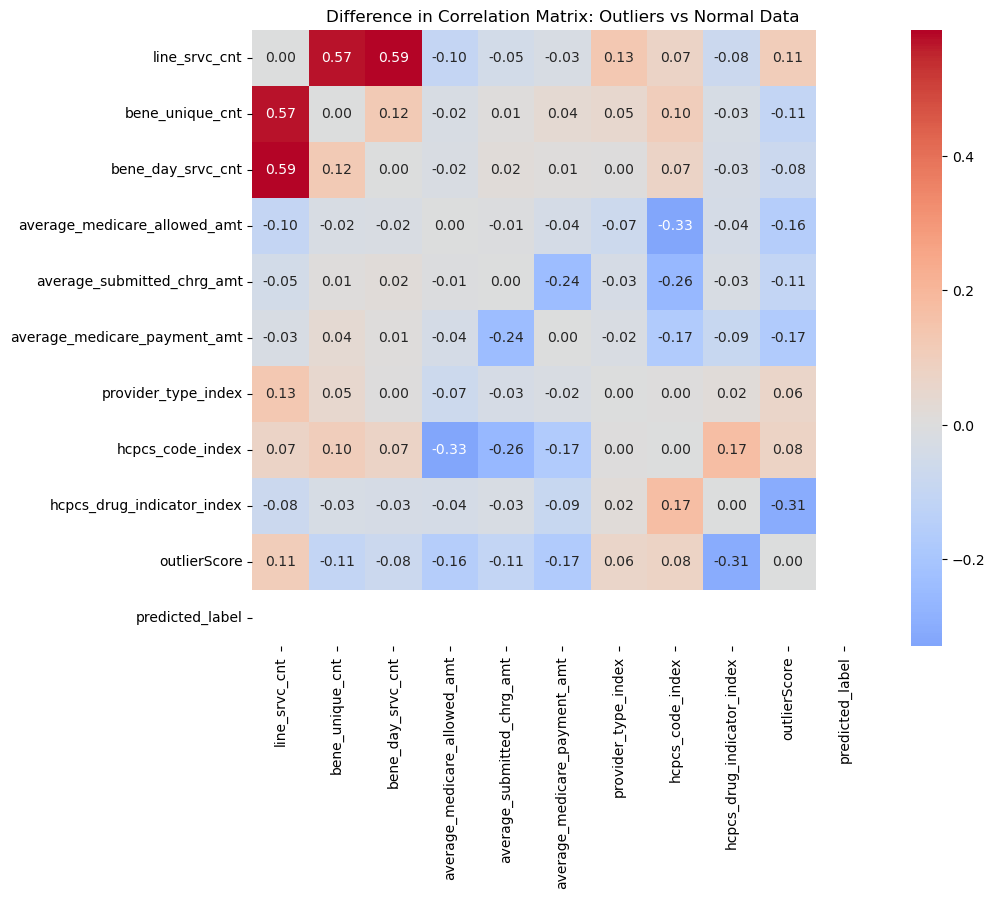

In [31]:
corr_matrix_outliers = outliers_df.corr()
corr_matrix_normal = normal_df.corr()

corr_difference = corr_matrix_outliers - corr_matrix_normal

heatmap_correlation_diff = plt.figure(figsize=(10, 8))
sns.heatmap(corr_difference, annot=True, fmt=".2f", cmap='coolwarm', center=0) \
                            .set_title('Difference in Correlation Matrix: Outliers vs Normal Data')



In [50]:
import io
from google.cloud import storage

# Connect to Google Cloud Storage
storage_client = storage.Client()
# Point to the bucket on Google Cloud Storage
bucket = storage_client.get_bucket('my-bigdata-project-ar')

In [51]:
# Saving a Seaborn plot to GCS

img_data = io.BytesIO()

heatmap_correlation_diff.savefig(img_data, format='png', bbox_inches='tight')

img_data.seek(0)


blob = bucket.blob("visuals/correlation_diff_heatmap.png")
blob.upload_from_file(img_data)


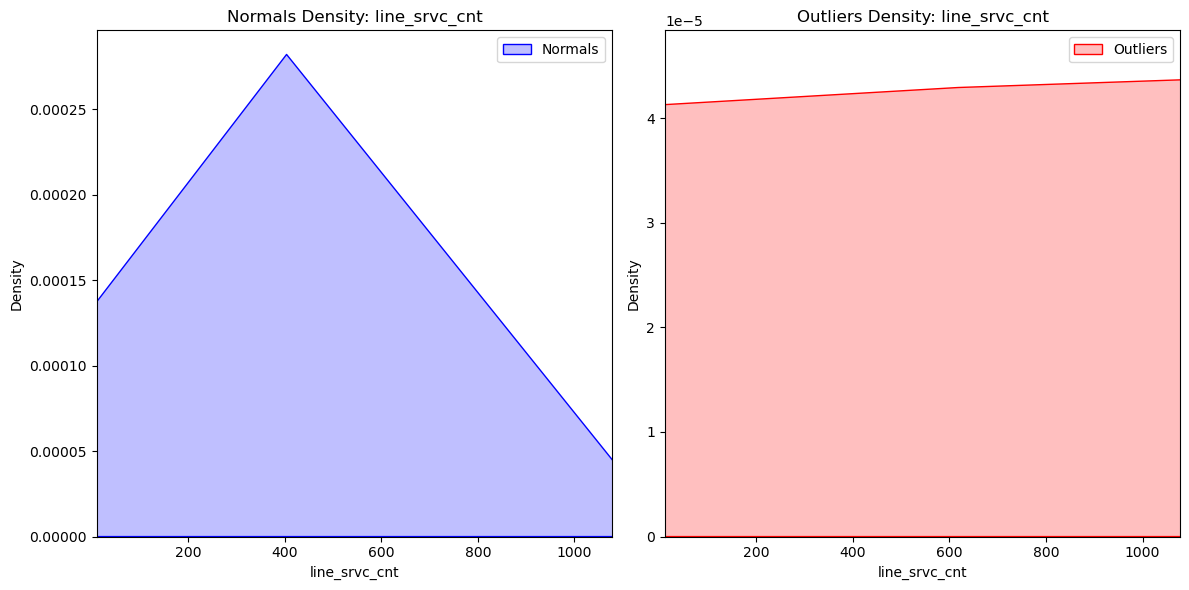

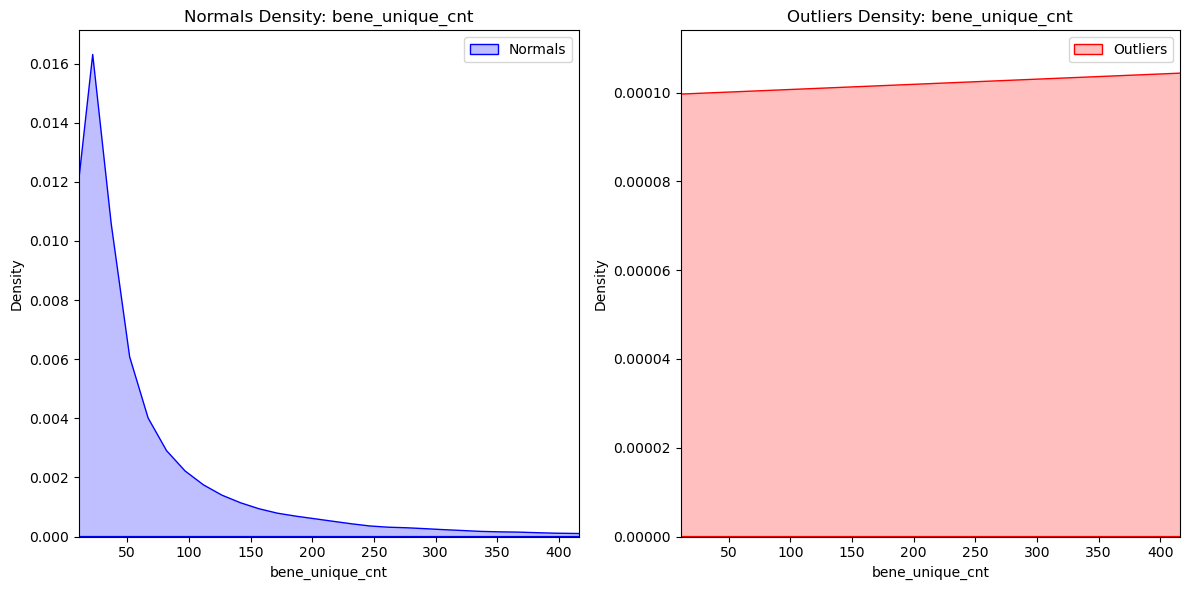

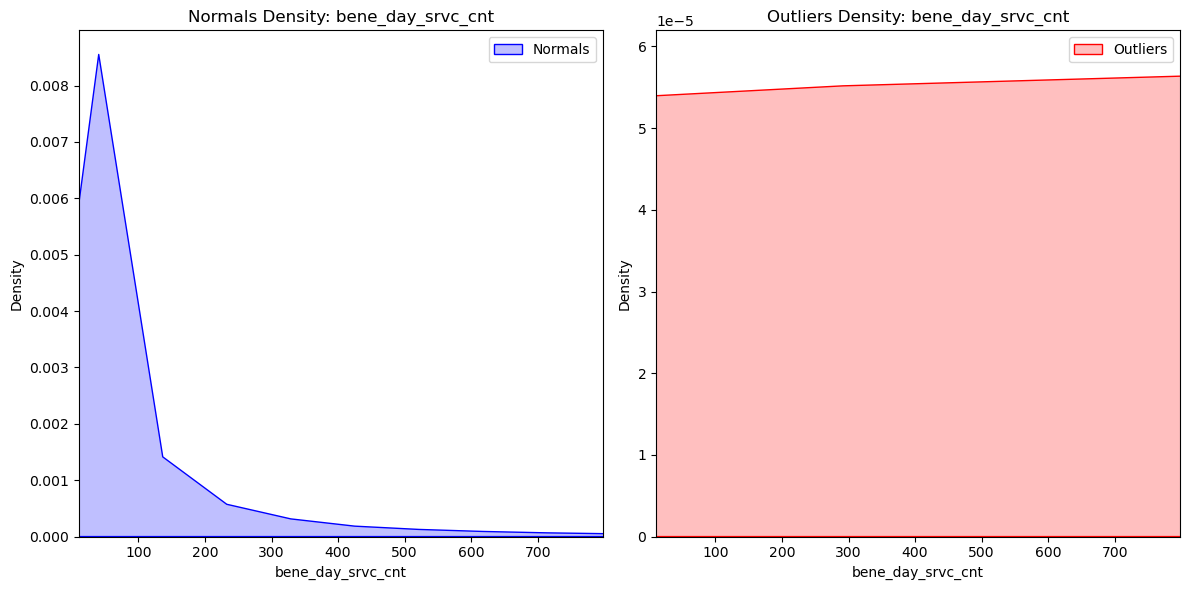

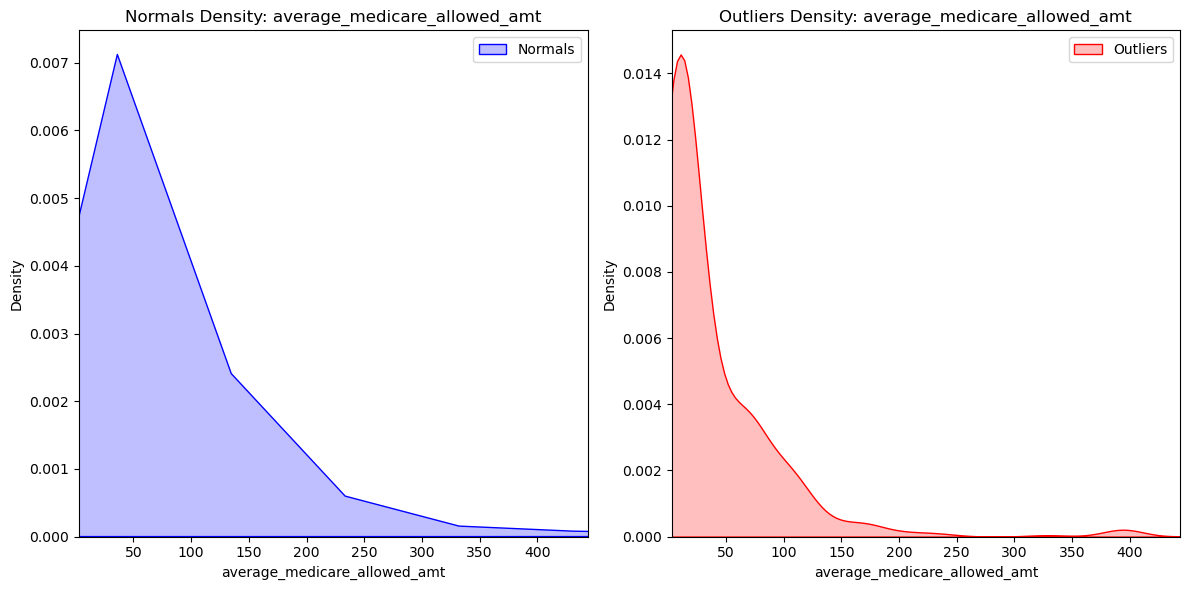

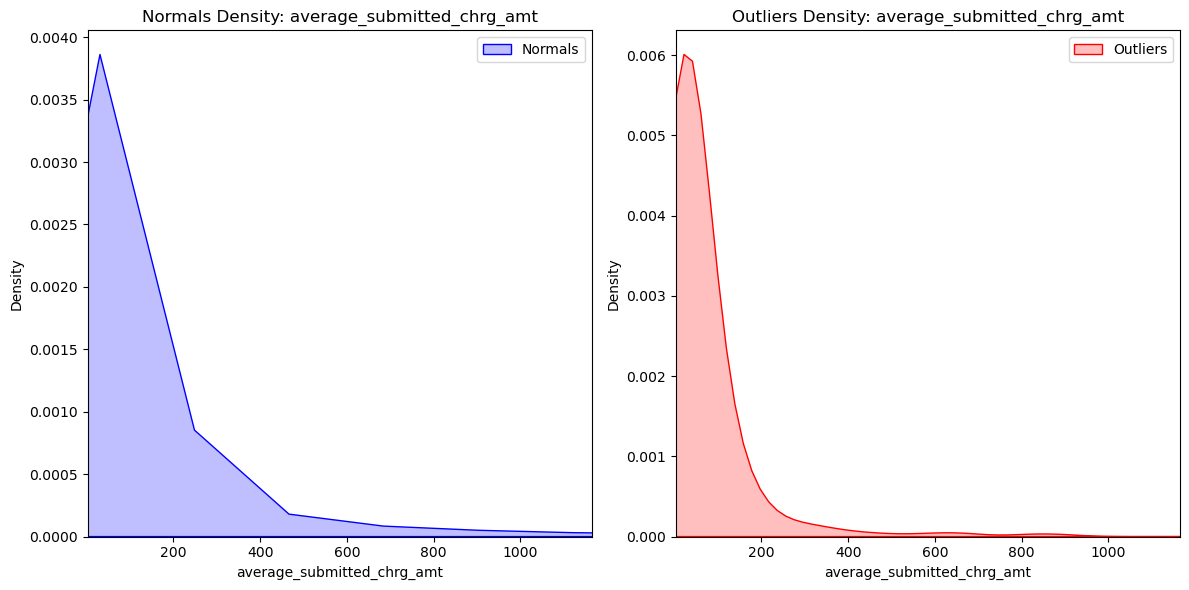

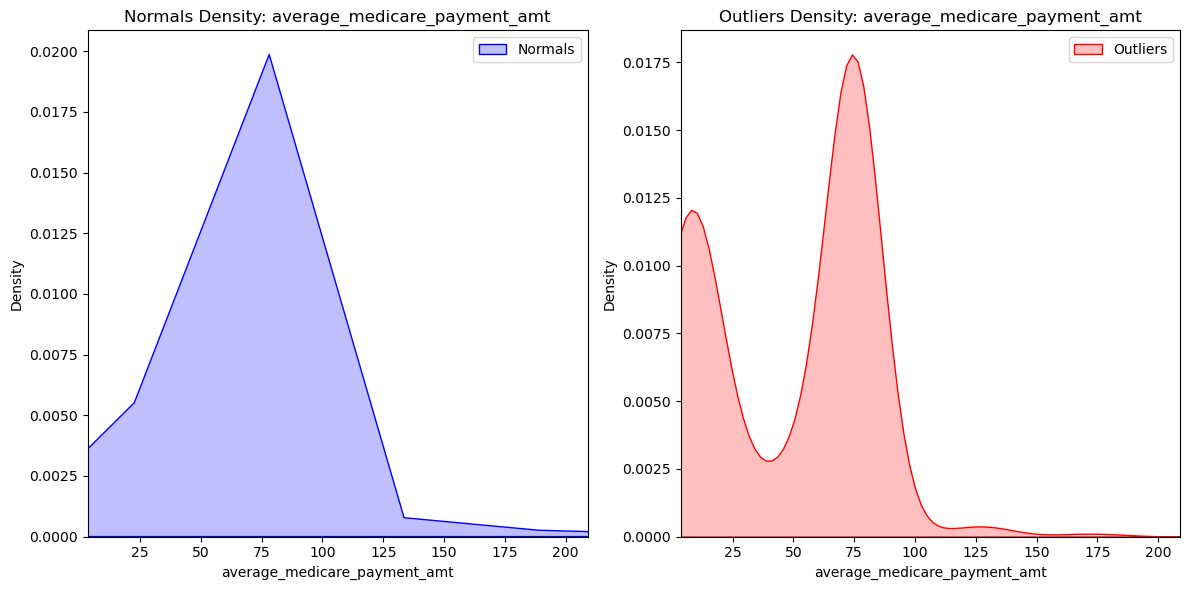

In [52]:
numeric_cols = ['line_srvc_cnt', 'bene_unique_cnt', 'bene_day_srvc_cnt',
              'average_medicare_allowed_amt', 'average_submitted_chrg_amt',
              'average_medicare_payment_amt']


for column in numeric_cols:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    combined_data = pd.concat([outliers_df[column], normal_df[column]])
    lower_bound, upper_bound = combined_data.quantile([0.025, 0.975])
    
    normal_density_plot = sns.kdeplot(normal_df[column], ax=axes[0], label='Normals', fill=True, color='blue')
    axes[0].set_xlim(lower_bound, upper_bound)
    axes[0].set_title(f'Normals Density: {column}')
    axes[0].legend()

    outlier_density_plot = sns.kdeplot(outliers_df[column], ax=axes[1], label='Outliers', fill=True, color='red')
    axes[1].set_xlim(lower_bound, upper_bound)
    axes[1].set_title(f'Outliers Density: {column}')
    axes[1].legend()
    

    plt.tight_layout()
    plt.show()

        
    img_data = io.BytesIO()
    # Write the figure to the buffer
    fig.savefig(img_data, format='png', bbox_inches='tight')
    # Rewind the pointer to the start of the data
    img_data.seek(0)

    # Create a blob to hold the data. Give it a file name
    blob = bucket.blob(f'visuals/{column}_density_comparision.png')
    # Upload the img_data contents to the blob
    blob.upload_from_file(img_data)
    